In [22]:
# importing the dependent libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from tensorflow.keras import optimizers
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
import scipy
import tensorflow as tf
from tensorflow import keras

In [23]:
data = pd.read_csv('pressure_loss.csv')

In [24]:
data.head()

,flow_rate_gpm,annulus,ecc,di/do,test_fluid,shear_pa,k,m,diff_p
0,18.50,annulus_1,1.0,0.27,XCD-PAC3,0.0,0.99,0.48,37.62
1,17.67,annulus_1,1.0,0.27,XCD-PAC3,0.0,0.99,0.48,36.97
2,16.92,annulus_1,1.0,0.27,XCD-PAC3,0.0,0.99,0.48,35.79
3,16.09,annulus_1,1.0,0.27,XCD-PAC3,0.0,0.99,0.48,34.97
4,15.17,annulus_1,1.0,0.27,XCD-PAC3,0.0,0.99,0.48,34.18


In [25]:
data['diff_p'] = data['diff_p']*0.24884

In [26]:
data = data.drop(['annulus','test_fluid'],axis=1)
dataset = data.values

In [27]:
x = dataset[:,:6]
y = dataset[:,6:]

In [28]:
scale_1 = MinMaxScaler(feature_range=(0,1))
scale_2 = MinMaxScaler(feature_range=(0,1))
x_scale = scale_1.fit_transform(x)
y_scale = scale_2.fit_transform(y)

In [29]:
# splitting the data
x_train,x_val, y_train,y_val = train_test_split(x_scale,y_scale,test_size=0.3)

In [30]:
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(632, 6) (632, 1) (271, 6) (271, 1)


In [31]:
# create model in keras
model = Sequential([
    Dense(3,activation='relu',input_shape=(6,)),
    Dense(3,activation='relu'),
    Dropout(0.15),
    Dense(1,activation='linear'),
])

In [32]:
model.compile(optimizer='adam',
             loss='mean_squared_error',
              metrics=['mae','mape','mse']
             )

In [33]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch%100 ==0: print('')
        print('.',end='')
history = model.fit(x_train,y_train,batch_size=16, epochs=1000,validation_split=0.2,
                    verbose=0,callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
995,0.010564,0.047308,309.965698,0.010564,0.002076,0.035507,178.162796,0.002076,995
996,0.008105,0.042978,324.355774,0.008105,0.002811,0.037640,160.652496,0.002811,996
997,0.006266,0.038945,277.552246,0.006266,0.001840,0.031400,145.655746,0.001840,997
998,0.009604,0.042562,283.434296,0.009604,0.002045,0.033032,151.482697,0.002045,998
999,0.010761,0.045774,295.765106,0.010761,0.002703,0.037256,165.361694,0.002703,999


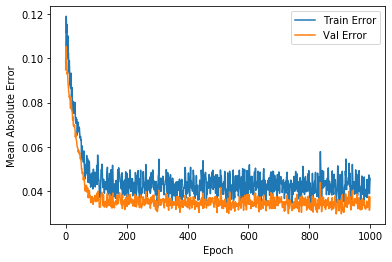

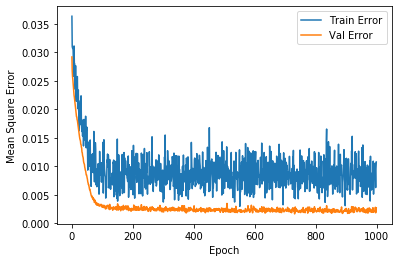

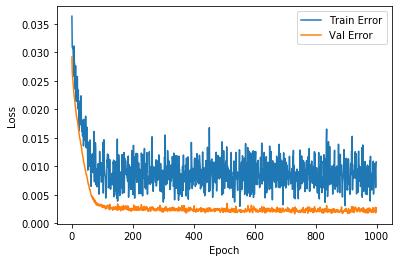

In [35]:
def plot_histry(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist['epoch'],hist['mae'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],label='Val Error')
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'],hist['mse'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mse'],label='Val Error')
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'],hist['loss'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_loss'],label='Val Error')
    plt.legend()

    
plot_histry(history)

In [36]:
test_error_rate = model.evaluate(x_train, y_train, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: [0.003132138454319933, 0.038844895, 276.6478, 0.0031321384]


In [37]:
model.evaluate(x_val,y_val)

271/271 [==============================] - 0s 37us/sample - loss: 0.0034 - mae: 0.0392 - mape: 179446.0156 - mse: 0.0034


[0.003409094803509512, 0.039213467, 179446.02, 0.0034090946]

In [38]:
predict = model.predict(x_val)

In [39]:
y_pred = scale_2.inverse_transform(predict)
y_real = scale_2.inverse_transform(y_val)

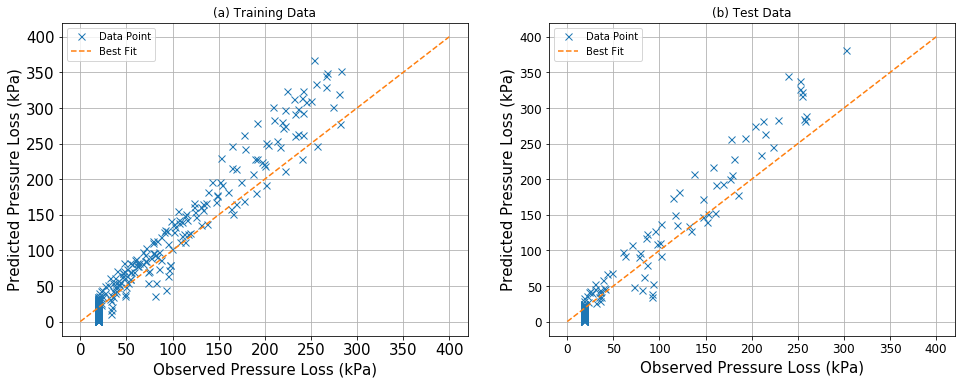

In [41]:
# plot trainning and test data 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
#fig.suptitle('Artificial Neural Network', fontsize=16)
fig.subplots_adjust(top=.85, wspace=0.2)



# first track
ax[0].plot(scale_2.inverse_transform(model.predict(x_train)),scale_2.inverse_transform(y_train),'x',label='Data Point',ms=7)
ax[0].set_ylabel('Predicted Pressure Loss (kPa)',fontsize=15)
ax[0].set_xlabel('Observed Pressure Loss (kPa)',fontsize=15)
ax[0].grid(True)
ax[0].set_title('(a) Training Data')
ax[0].plot([0,400],[0,400],'--',label='Best Fit')
ax[0].legend()
ax[0].tick_params(labelsize=15)

# second track
ax[1].plot(y_pred,y_real,'x',label='Data Point',ms=7)
ax[1].set_ylabel('Predicted Pressure Loss (kPa)',fontsize=15)
ax[1].set_xlabel('Observed Pressure Loss (kPa)',fontsize=15)
ax[1].grid(True)
ax[1].set_title('(b) Test Data')
ax[1].plot([0,400],[0,400],'--',label='Best Fit')
ax[1].legend()
ax[1].tick_params(labelsize=12)
#plt.rcParams.update({'font.size':10})
#plt.savefig('ANN.jpeg',dpi=200)